In [1]:
# Importing Required Python Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

In [2]:
# Loading Training set
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

In [3]:
# Loading Test set
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

### Since the dataset is highly imbalanced, the metric of choice is roc_auc score. So we would use tis metric to tune various ML models and select the best.

## Baseline Model: Dummy Classifier with Default Parameters 

In [4]:
# Importing Dummy classifier from Scikit Learn
from sklearn.dummy import DummyClassifier

In [5]:
# Importing the Sklearn's roc_auc_score module
from sklearn.metrics import roc_auc_score

In [6]:
# Instantiating the Dummy classifier object
bm = DummyClassifier(random_state=42,strategy='most_frequent')

In [7]:
# Fitting the  dummy classifier to Training set.
bm.fit(X_train,y_train)

DummyClassifier(random_state=42, strategy='most_frequent')

In [8]:
# Accuracy for the Training set with baseline model
print('The training set accuracy is: ',bm.score(X_train,y_train))

The training set accuracy is:  0.623925


In [9]:
# Predicting the probabilities of y=1 for the training set
y_pred_train = bm.predict_proba(X_train)

In [10]:
print('The roc_auc score for the Training set is:',roc_auc_score(y_train,y_pred_train[:,1]))

The roc_auc score for the Training set is: 0.5


In [11]:
# Predicting the probabilities of y=1 for the test set
y_pred = bm.predict_proba(X_test)

In [12]:
print('The roc_auc score for the test set is:',roc_auc_score(y_test,y_pred[:,1]))

The roc_auc score for the test set is: 0.5


### Thus we observe that roc_auc score for the baseline model is .5, which is equal to that of random guessing.

## Model_1: Random Forest Classifier with Tuned Hyperparameters using Optuna.

In [13]:
# Importing  hyperparamater tuning optimizer optuna
import optuna

In [14]:
# Importing required Libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [15]:
# Instantiating the Stratified K fold object
cv_strat = StratifiedKFold(5,random_state=42)

In [16]:
# Defining the class weights
cl_weight = ['balanced',{0:1.0,1:2.0},{0:1.0,1:3.0},{0:1.0,1:4.0},{0:1.0,1:5.0}]

In [17]:
# Defining the appropriate objective function for the Random Forest classifier
def objective_wrappper_rf(X_tr, y_tr, cls=None, cv_strat=None):
    '''
    Optimizes Random Forest parameters on the given training set X_tr,y_tr
    using cv_strat cross-validation object
    
    '''
    
    def objective(trial):
        params = {
        'max_depth': trial.suggest_categorical('max_depth',list(range(2,50))+ [None]),
        'n_estimators':trial.suggest_int('n_estimators',100,2000,10),
        'class_weight':trial.suggest_categorical('class_weight',cl_weight),
        'min_samples_leaf':trial.suggest_loguniform('min_samples_leaf',.00001,.1)
          }
        
        cls.set_params(**params)#Initializing the model with the parameters 
    
        return np.mean(cross_val_score(cls, X_tr, y_tr, cv=cv_strat, n_jobs=5, scoring='roc_auc'))  
    return objective

In [18]:
# Defining the evaluation function for study's best parameters
def study_params(X_tr, y_tr, cls, obj_func, cv_strat, n_trials=30):
    ''' Computes the best hyper parameters of the classsifier and returns 
    Optuna's study's best score & clasifier parameters'''
    study = optuna.create_study(direction='maximize')
    study.optimize(obj_func(X_tr, y_tr, cls, cv_strat), n_trials)
    best_score = study.best_value
    best_params = study.best_params
    return (best_score,best_params)

In [19]:
# Importing Random Forest Classifier from  Sklearn
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Instantiating the Random forest classifier
rf_s = RandomForestClassifier(n_jobs=5, random_state=42)

#### Computing the best hyperparameters for the Random Forest classifier using Training Set.

In [22]:
# Extracting the best model parameters and best study score
best_study_score,best_study_params = study_params(X_train, y_train, rf_s, objective_wrappper_rf, cv_strat)

[I 2021-03-05 15:10:18,584] A new study created in memory with name: no-name-8b771015-3b37-4a81-8b63-c0ab281d5085
[I 2021-03-05 15:10:30,924] Trial 0 finished with value: 0.8835275634416359 and parameters: {'max_depth': 35, 'n_estimators': 790, 'class_weight': {0: 1.0, 1: 4.0}, 'min_samples_leaf': 0.00013592187551086346}. Best is trial 0 with value: 0.8835275634416359.
[I 2021-03-05 15:10:59,631] Trial 1 finished with value: 0.879610400551648 and parameters: {'max_depth': 40, 'n_estimators': 1710, 'class_weight': {0: 1.0, 1: 2.0}, 'min_samples_leaf': 5.344801343356602e-05}. Best is trial 0 with value: 0.8835275634416359.
[I 2021-03-05 15:11:11,315] Trial 2 finished with value: 0.8752199507677523 and parameters: {'max_depth': 30, 'n_estimators': 1030, 'class_weight': {0: 1.0, 1: 5.0}, 'min_samples_leaf': 0.001744019650871022}. Best is trial 0 with value: 0.8835275634416359.
[I 2021-03-05 15:11:44,624] Trial 3 finished with value: 0.8653551256430487 and parameters: {'max_depth': 47, 'n_e

In [23]:
print('The best roc_auc_score for the study is: ', best_study_score)

The best roc_auc_score for the study is:  0.8840424006631341


In [24]:
print(('The best study parameters for the classifier are: ', best_study_params))

('The best study parameters for the classifier are: ', {'max_depth': 19, 'n_estimators': 600, 'class_weight': {0: 1.0, 1: 3.0}, 'min_samples_leaf': 0.0002884253292983611})


In [25]:
# Obtaining the tuned RF model by setting best study parameters.
rf_s = rf_s.set_params(**best_study_params)

In [27]:
# fitting the best Random Forest model on the training set
rf_s.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 1.0, 1: 3.0}, max_depth=19,
                       min_samples_leaf=0.0002884253292983611, n_estimators=600,
                       n_jobs=5, random_state=42)

In [28]:
# Defining the function to calculate the roc_auc score for the feature sets
def cal_roc_auc(X, y, cls, f_set, t_set, model_name):
    ''' Calculates the roc auc score using the best study parameters 
        f_set : String: specifies 'full feature', 'Reduced feature'
        t_set: String: specifies 'training', 'test'
        model_name: String: specifies Name of the model '''
        
    y_pred = cls.predict_proba(X)
    print('The roc_auc_score for the {} {} set using the tuned {} classifier is '.format(f_set, t_set, model_name), roc_auc_score(y,y_pred[:,1]))

In [29]:
# Calculating the full feature training set roc_auc score using the best study parameters
cal_roc_auc(X_train, y_train, rf_s, '', 'training', 'Random Forest')

The roc_auc_score for the  training set using the tuned Random Forest classifier is  0.9183677451507892


In [30]:
# Calculating the full feature test set roc_auc score using the best study parameters
cal_roc_auc(X_test, y_test, rf_s, '', 'test', 'Random Forest')

The roc_auc_score for the  test set using the tuned Random Forest classifier is  0.887408560683394


In [31]:
### Obtaining the feature importances of the dataset set features.
feature_imp = pd.Series(rf_s.feature_importances_,index=X_train.columns)

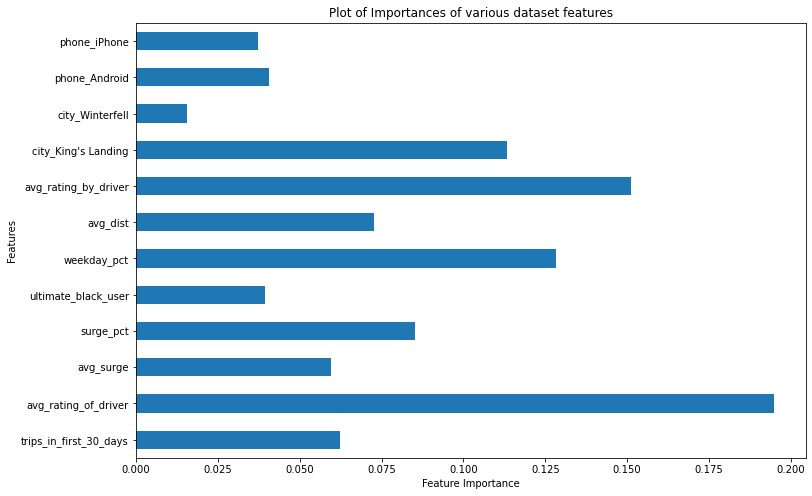

In [32]:
# Plotting the feature importances of the various features
plt.figure(figsize=(12,8))
feature_imp.plot.barh()
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Plot of Importances of various dataset features')
plt.show()

###  From the above plot, we can clearly make out that the most important feature for prediction purposes are : avg_rating_of_driver,  avg_rating_by_driver, weekday_pct and so on.

### Observations:
### 1) The random forest classifier has beautifully fitted the dataset , with no apparent signs of overfitting.
### 2) Since the Random Forest test set roc_auc score is way above that of the baseline model, RF indeed has good prediction power.

In [33]:
# Saving the reduced feature set best Random forest Classifier 
import joblib
joblib.dump(rf_s,'Rand_Forest.joblib')

['Rand_Forest.joblib']

## Model_2:  Keras Variable Layer Dense Model with Equal No. of Neurons/layer  , SELU Activation &  Tuned learning rate.

In [34]:
# Defining the ratio of class 0 to class 1
balanced = (y_train.value_counts().loc[0].values[0])/(y_train.value_counts().loc[1].values[0])

In [35]:
balanced

1.6590440736555208

In [36]:
cl_weight_neural = [{0:1.0,1:balanced},{0:1.0,1:2.0},{0:1.0,1:3.0},{0:1.0,1:4.0},{0:1.0,1:5.0}]

In [37]:
# defining the objective function
def objective_wrappper_keras_eq(X_tr, y_tr, X_val, y_val, cl_weight):
    '''
    Optimizes Keras ,neural net with equal no. of neurons in each layer , best parameters 
    on the given training set: X_tr, y_tr using validation set: X_val,y_val & class weights: cl_weight
    
    '''

    def objective(trial):
        s = trial.suggest_int('step',2,5)
        def exponential_decay_fn(epoch):
            return 0.01 * 0.1**(epoch /s )
              
        # building model & searching for the best no. of neural units per layer.
        no_units = trial.suggest_int('no._units',100,500)# No. of Neurons in each layer
        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=X_tr.shape[1:]))
        model.add(keras.layers.BatchNormalization())
        for i in range(trial.suggest_int('number',2,5)):
            model.add(keras.layers.Dense(units=no_units,activation='selu',
                                     kernel_initializer='lecun_normal')) # For self normalization
        model.add(keras.layers.Dense(units=1,activation='sigmoid'))
    
            
        # Compiling the model
        model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(beta_1=0.9, beta_2=0.999), 
                      metrics=["accuracy"])
    
        # Defining the Callbacks
        checkpoint_cb = keras.callbacks.ModelCheckpoint('best_model.h5',save_best_only=True) # 1st Callback
        early_stopping_cb = keras.callbacks.EarlyStopping(patience=10) # 2nd Callback, Stop if validation score doen't improve for
        # 10 epochs        
        lr_scheduler_cb = keras.callbacks.LearningRateScheduler(exponential_decay_fn)# 3rd Callback
        
        #Fitting the model
        model.fit(X_tr,y_tr,epochs=50,validation_data=(X_val,y_val),batch_size=32,
             class_weight=trial.suggest_categorical('best_weight',cl_weight),
             callbacks=[checkpoint_cb,early_stopping_cb,lr_scheduler_cb])
    
        # Loading the best model 
        model_best = keras.models.load_model('best_model.h5')
    
        # Computing the roc_auc_score for the validation set
        roc_auc_1 = roc_auc_score(y_val,model_best.predict(X_val))
        global best_roc_auc
        # Updating best_roc_auc score
        if roc_auc_1 > best_roc_auc:
            best_roc_auc = roc_auc_1
            model_best.save('Best_model_Selu_eq_Learn.h5')
        
        return roc_auc_1
    
    return objective

In [38]:
# Importing train test split from Sklearn to produce validation set
from sklearn.model_selection import train_test_split

In [39]:
# Performing train validation split with test size = .15 to provide more Training data to Neural Net
X_train_1, X_val, y_train_1, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42,
                                                          stratify=y_train)

In [40]:
# Defining the evaluation function for study's best parameters
def study_params_neural(X_tr, y_tr, X_v, y_v, obj_func, cl_weight, n_trials=50):
    ''' Computes the best hyper parameters of the Neural net using the Training set(X_tr,y_tr) & Validation set
    (X_v,y_v), class weights cl_wei & 
    returns Optuna's study's best score & clasifier parameters'''
    
    study = optuna.create_study(direction='maximize')
    study.optimize(obj_func(X_tr, y_tr, X_v, y_v, cl_weight),n_trials)
    best_score = study.best_value
    best_params = study.best_params
    return (best_score,best_params)

In [41]:
# Importing tensorflow and keras
import tensorflow as tf
from tensorflow import keras 

In [64]:
# Extracting the best model parameters and best study score
best_roc_auc = 0
best_study_score,best_study_params = study_params_neural(X_train_1, y_train_1, X_val, y_val, objective_wrappper_keras_eq, 
                                                         cl_weight_neural)

[I 2021-03-05 17:17:27,559] A new study created in memory with name: no-name-c6457089-e235-4114-99f8-9821fa8ed1e3


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.2771 - accuracy: 0.6306 - val_loss: 0.5997 - val_accuracy: 0.7380
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7357 - accuracy: 0.7216 - val_loss: 0.5188 - val_accuracy: 0.7460
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6745 - accuracy: 0.7411 - val_loss: 0.5387 - val_accuracy: 0.7425
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6602 - accuracy: 0.7477 - val_loss: 0.5352 - val_accuracy: 0.7328
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6492 - accuracy: 0.7511 - val_loss: 0.4894 - val_accuracy: 0.7623
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6455 - accuracy: 0.7525 - val_loss: 0.5231 - val_accuracy: 0.7397
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6412 - accuracy: 0.7538 - val_loss: 0.4928 - val_accuracy:

[I 2021-03-05 17:18:04,468] Trial 0 finished with value: 0.8310591864240467 and parameters: {'step': 3, 'no._units': 415, 'number': 3, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 0 with value: 0.8310591864240467.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.6056 - accuracy: 0.5429 - val_loss: 0.5734 - val_accuracy: 0.7018
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.2052 - accuracy: 0.5883 - val_loss: 2.4715 - val_accuracy: 0.3760
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.1262 - accuracy: 0.6071 - val_loss: 0.5304 - val_accuracy: 0.7420
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0914 - accuracy: 0.6207 - val_loss: 1.2265 - val_accuracy: 0.4478
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0802 - accuracy: 0.6198 - val_loss: 0.6919 - val_accuracy: 0.6405
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0656 - accuracy: 0.6242 - val_loss: 0.6611 - val_accuracy: 0.6770
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0602 - accuracy: 0.6290 - val_loss: 0.7231 - val_accuracy:

[I 2021-03-05 17:18:37,508] Trial 1 finished with value: 0.8253805971350852 and parameters: {'step': 4, 'no._units': 220, 'number': 4, 'best_weight': {0: 1.0, 1: 5.0}}. Best is trial 0 with value: 0.8310591864240467.


Epoch 1/50
1063/1063 [==============================] - 3s 3ms/step - loss: 4.3119 - accuracy: 0.5011 - val_loss: 0.9461 - val_accuracy: 0.3760
Epoch 2/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.2308 - accuracy: 0.4179 - val_loss: 1.2481 - val_accuracy: 0.3760
Epoch 3/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.1854 - accuracy: 0.4004 - val_loss: 1.0305 - val_accuracy: 0.3760
Epoch 4/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.1664 - accuracy: 0.3854 - val_loss: 0.7273 - val_accuracy: 0.3760
Epoch 5/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.1550 - accuracy: 0.3835 - val_loss: 0.7929 - val_accuracy: 0.3760
Epoch 6/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.1502 - accuracy: 0.3769 - val_loss: 0.7418 - val_accuracy: 0.3760
Epoch 7/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.1488 - accuracy: 0.3761 - val_loss: 0.7546 - val_accuracy:

[I 2021-03-05 17:19:19,581] Trial 2 finished with value: 0.5 and parameters: {'step': 5, 'no._units': 379, 'number': 5, 'best_weight': {0: 1.0, 1: 3.0}}. Best is trial 0 with value: 0.8310591864240467.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.4875 - accuracy: 0.5554 - val_loss: 0.6083 - val_accuracy: 0.7037
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.1647 - accuracy: 0.5965 - val_loss: 0.8640 - val_accuracy: 0.4502
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.1033 - accuracy: 0.6178 - val_loss: 0.6000 - val_accuracy: 0.7083
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0789 - accuracy: 0.6263 - val_loss: 0.7609 - val_accuracy: 0.6087
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0626 - accuracy: 0.6315 - val_loss: 0.7616 - val_accuracy: 0.6288
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0546 - accuracy: 0.6369 - val_loss: 0.7592 - val_accuracy: 0.6193
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0487 - accuracy: 0.6335 - val_loss: 0.7044 - val_accuracy:

[I 2021-03-05 17:19:49,572] Trial 3 finished with value: 0.8303620307859004 and parameters: {'step': 3, 'no._units': 226, 'number': 3, 'best_weight': {0: 1.0, 1: 5.0}}. Best is trial 0 with value: 0.8310591864240467.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.3625 - accuracy: 0.6229 - val_loss: 1.8055 - val_accuracy: 0.6360
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8238 - accuracy: 0.6920 - val_loss: 0.5737 - val_accuracy: 0.7242
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7140 - accuracy: 0.7290 - val_loss: 0.5044 - val_accuracy: 0.7630
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6803 - accuracy: 0.7383 - val_loss: 0.5018 - val_accuracy: 0.7628
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6669 - accuracy: 0.7445 - val_loss: 0.4936 - val_accuracy: 0.7642
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6525 - accuracy: 0.7471 - val_loss: 0.5162 - val_accuracy: 0.7478
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6472 - accuracy: 0.7521 - val_loss: 0.5149 - val_accuracy:

[I 2021-03-05 17:20:27,082] Trial 4 finished with value: 0.8296779575453113 and parameters: {'step': 5, 'no._units': 451, 'number': 3, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 0 with value: 0.8310591864240467.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7502 - accuracy: 0.7070 - val_loss: 0.6069 - val_accuracy: 0.6625
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6774 - accuracy: 0.7334 - val_loss: 0.5529 - val_accuracy: 0.7227
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6586 - accuracy: 0.7425 - val_loss: 0.5301 - val_accuracy: 0.7402
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6503 - accuracy: 0.7478 - val_loss: 0.5247 - val_accuracy: 0.7365
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6428 - accuracy: 0.7509 - val_loss: 0.5019 - val_accuracy: 0.7592
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6413 - accuracy: 0.7507 - val_loss: 0.5094 - val_accuracy: 0.7518
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6373 - accuracy: 0.7542 - val_loss: 0.5108 - val_accuracy:

[I 2021-03-05 17:21:01,744] Trial 5 finished with value: 0.8321222940155785 and parameters: {'step': 4, 'no._units': 244, 'number': 2, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 5 with value: 0.8321222940155785.


Epoch 1/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.1837 - accuracy: 0.5878 - val_loss: 0.8853 - val_accuracy: 0.4060
Epoch 2/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.0178 - accuracy: 0.6457 - val_loss: 0.5173 - val_accuracy: 0.7437
Epoch 3/50
1063/1063 [==============================] - 3s 3ms/step - loss: 0.9898 - accuracy: 0.6556 - val_loss: 0.7281 - val_accuracy: 0.6188
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9762 - accuracy: 0.6556 - val_loss: 0.6778 - val_accuracy: 0.6460
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9652 - accuracy: 0.6590 - val_loss: 0.6529 - val_accuracy: 0.6660
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9666 - accuracy: 0.6629 - val_loss: 0.6681 - val_accuracy: 0.6577
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9665 - accuracy: 0.6610 - val_loss: 0.6602 - val_accuracy:

[I 2021-03-05 17:21:33,108] Trial 6 finished with value: 0.8209756769223191 and parameters: {'step': 2, 'no._units': 124, 'number': 4, 'best_weight': {0: 1.0, 1: 4.0}}. Best is trial 5 with value: 0.8321222940155785.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.1828 - accuracy: 0.5960 - val_loss: 0.6772 - val_accuracy: 0.6245
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0361 - accuracy: 0.6259 - val_loss: 0.6479 - val_accuracy: 0.6445
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0086 - accuracy: 0.6385 - val_loss: 0.7364 - val_accuracy: 0.6338
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9911 - accuracy: 0.6525 - val_loss: 0.7000 - val_accuracy: 0.6267
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9783 - accuracy: 0.6569 - val_loss: 0.6701 - val_accuracy: 0.6463
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9764 - accuracy: 0.6543 - val_loss: 0.6290 - val_accuracy: 0.6968
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9658 - accuracy: 0.6612 - val_loss: 0.6681 - val_accuracy:

[I 2021-03-05 17:22:07,580] Trial 7 finished with value: 0.8305698100412197 and parameters: {'step': 5, 'no._units': 272, 'number': 2, 'best_weight': {0: 1.0, 1: 4.0}}. Best is trial 5 with value: 0.8321222940155785.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0024 - accuracy: 0.6434 - val_loss: 0.6049 - val_accuracy: 0.7017
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8881 - accuracy: 0.6940 - val_loss: 0.5430 - val_accuracy: 0.7357
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8654 - accuracy: 0.7034 - val_loss: 0.6135 - val_accuracy: 0.6998
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8518 - accuracy: 0.7039 - val_loss: 0.5985 - val_accuracy: 0.7088
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8463 - accuracy: 0.7059 - val_loss: 0.5763 - val_accuracy: 0.7188
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8449 - accuracy: 0.7074 - val_loss: 0.5845 - val_accuracy: 0.7167
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8447 - accuracy: 0.7070 - val_loss: 0.5865 - val_accuracy:

[I 2021-03-05 17:22:35,055] Trial 8 finished with value: 0.8226072472457114 and parameters: {'step': 2, 'no._units': 139, 'number': 3, 'best_weight': {0: 1.0, 1: 3.0}}. Best is trial 5 with value: 0.8321222940155785.


Epoch 1/50
1063/1063 [==============================] - 3s 3ms/step - loss: 2.2533 - accuracy: 0.5109 - val_loss: 0.7946 - val_accuracy: 0.7068
Epoch 2/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.3540 - accuracy: 0.5683 - val_loss: 0.5611 - val_accuracy: 0.7288
Epoch 3/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1855 - accuracy: 0.6025 - val_loss: 0.5015 - val_accuracy: 0.7583
Epoch 4/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1361 - accuracy: 0.6100 - val_loss: 0.6955 - val_accuracy: 0.6435
Epoch 5/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1037 - accuracy: 0.6131 - val_loss: 0.7398 - val_accuracy: 0.6477
Epoch 6/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.0878 - accuracy: 0.6207 - val_loss: 0.8317 - val_accuracy: 0.5738
Epoch 7/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.0722 - accuracy: 0.6240 - val_loss: 0.7190 - val_accuracy:

[I 2021-03-05 17:23:10,443] Trial 9 finished with value: 0.8161804158521246 and parameters: {'step': 5, 'no._units': 398, 'number': 4, 'best_weight': {0: 1.0, 1: 5.0}}. Best is trial 5 with value: 0.8321222940155785.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8426 - accuracy: 0.6832 - val_loss: 0.5611 - val_accuracy: 0.7158
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7441 - accuracy: 0.7169 - val_loss: 0.5587 - val_accuracy: 0.7213
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7316 - accuracy: 0.7250 - val_loss: 0.5570 - val_accuracy: 0.7247
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7216 - accuracy: 0.7296 - val_loss: 0.5349 - val_accuracy: 0.7318
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7146 - accuracy: 0.7346 - val_loss: 0.5411 - val_accuracy: 0.7370
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7108 - accuracy: 0.7367 - val_loss: 0.5327 - val_accuracy: 0.7400
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7066 - accuracy: 0.7366 - val_loss: 0.5319 - val_accuracy:

[I 2021-03-05 17:24:15,485] Trial 10 finished with value: 0.8322957393768563 and parameters: {'step': 4, 'no._units': 313, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 10 with value: 0.8322957393768563.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8465 - accuracy: 0.6792 - val_loss: 0.5740 - val_accuracy: 0.6983
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7439 - accuracy: 0.7196 - val_loss: 0.5570 - val_accuracy: 0.7350
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7312 - accuracy: 0.7289 - val_loss: 0.5608 - val_accuracy: 0.7245
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7200 - accuracy: 0.7298 - val_loss: 0.5776 - val_accuracy: 0.7040
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7143 - accuracy: 0.7352 - val_loss: 0.5477 - val_accuracy: 0.7295
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7058 - accuracy: 0.7376 - val_loss: 0.5355 - val_accuracy: 0.7363
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7033 - accuracy: 0.7392 - val_loss: 0.5324 - val_accuracy:

[I 2021-03-05 17:25:04,352] Trial 11 finished with value: 0.8344829860163969 and parameters: {'step': 4, 'no._units': 323, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8582 - accuracy: 0.6816 - val_loss: 0.5475 - val_accuracy: 0.7133
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7470 - accuracy: 0.7184 - val_loss: 0.5357 - val_accuracy: 0.7387
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7304 - accuracy: 0.7270 - val_loss: 0.5101 - val_accuracy: 0.7528
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7202 - accuracy: 0.7327 - val_loss: 0.5437 - val_accuracy: 0.7308
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7098 - accuracy: 0.7360 - val_loss: 0.5422 - val_accuracy: 0.7290
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7035 - accuracy: 0.7380 - val_loss: 0.5222 - val_accuracy: 0.7418
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7020 - accuracy: 0.7421 - val_loss: 0.5177 - val_accuracy:

[I 2021-03-05 17:25:32,364] Trial 12 finished with value: 0.8198170855875311 and parameters: {'step': 4, 'no._units': 329, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8555 - accuracy: 0.6774 - val_loss: 0.5636 - val_accuracy: 0.7182
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7473 - accuracy: 0.7165 - val_loss: 0.5424 - val_accuracy: 0.7305
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7308 - accuracy: 0.7289 - val_loss: 0.5315 - val_accuracy: 0.7337
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7180 - accuracy: 0.7316 - val_loss: 0.5506 - val_accuracy: 0.7298
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7106 - accuracy: 0.7344 - val_loss: 0.5286 - val_accuracy: 0.7383
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7049 - accuracy: 0.7388 - val_loss: 0.5372 - val_accuracy: 0.7370
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7012 - accuracy: 0.7409 - val_loss: 0.5333 - val_accuracy:

[I 2021-03-05 17:26:30,649] Trial 13 finished with value: 0.8339252378273323 and parameters: {'step': 4, 'no._units': 336, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9250 - accuracy: 0.6696 - val_loss: 0.6815 - val_accuracy: 0.6130
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7446 - accuracy: 0.7201 - val_loss: 0.5414 - val_accuracy: 0.7333
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7263 - accuracy: 0.7289 - val_loss: 0.5510 - val_accuracy: 0.7297
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7173 - accuracy: 0.7325 - val_loss: 0.5422 - val_accuracy: 0.7307
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7063 - accuracy: 0.7359 - val_loss: 0.5324 - val_accuracy: 0.7398
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7055 - accuracy: 0.7391 - val_loss: 0.5406 - val_accuracy: 0.7328
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7018 - accuracy: 0.7415 - val_loss: 0.5276 - val_accuracy:

[I 2021-03-05 17:27:07,991] Trial 14 finished with value: 0.8322124500856216 and parameters: {'step': 3, 'no._units': 499, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8549 - accuracy: 0.6811 - val_loss: 0.6277 - val_accuracy: 0.6607
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7455 - accuracy: 0.7185 - val_loss: 0.5312 - val_accuracy: 0.7435
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7275 - accuracy: 0.7299 - val_loss: 0.5555 - val_accuracy: 0.7240
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7228 - accuracy: 0.7312 - val_loss: 0.5752 - val_accuracy: 0.7123
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7123 - accuracy: 0.7348 - val_loss: 0.5526 - val_accuracy: 0.7278
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7097 - accuracy: 0.7361 - val_loss: 0.5358 - val_accuracy: 0.7405
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7041 - accuracy: 0.7385 - val_loss: 0.5322 - val_accuracy:

[I 2021-03-05 17:27:55,856] Trial 15 finished with value: 0.8330464677289809 and parameters: {'step': 4, 'no._units': 346, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8613 - accuracy: 0.6759 - val_loss: 0.5984 - val_accuracy: 0.6987
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7497 - accuracy: 0.7223 - val_loss: 0.6065 - val_accuracy: 0.6962
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7232 - accuracy: 0.7353 - val_loss: 0.5409 - val_accuracy: 0.7383
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7111 - accuracy: 0.7381 - val_loss: 0.4929 - val_accuracy: 0.7623
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7034 - accuracy: 0.7437 - val_loss: 0.5333 - val_accuracy: 0.7362
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6947 - accuracy: 0.7433 - val_loss: 0.5062 - val_accuracy: 0.7485
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6910 - accuracy: 0.7444 - val_loss: 0.5170 - val_accuracy:

[I 2021-03-05 17:28:28,165] Trial 16 finished with value: 0.8324649225995636 and parameters: {'step': 3, 'no._units': 173, 'number': 3, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.3715 - accuracy: 0.5382 - val_loss: 2.1891 - val_accuracy: 0.3760
Epoch 2/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.0089 - accuracy: 0.4730 - val_loss: 0.7517 - val_accuracy: 0.3760
Epoch 3/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.9715 - accuracy: 0.4501 - val_loss: 0.9640 - val_accuracy: 0.3760
Epoch 4/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.9608 - accuracy: 0.4373 - val_loss: 0.7628 - val_accuracy: 0.3760
Epoch 5/50
1063/1063 [==============================] - 3s 3ms/step - loss: 0.9563 - accuracy: 0.4196 - val_loss: 0.6723 - val_accuracy: 0.6240
Epoch 6/50
1063/1063 [==============================] - 3s 3ms/step - loss: 0.9534 - accuracy: 0.4055 - val_loss: 0.7122 - val_accuracy: 0.3760
Epoch 7/50
1063/1063 [==============================] - 3s 3ms/step - loss: 0.9510 - accuracy: 0.3927 - val_loss: 0.7026 - val_accuracy:

[I 2021-03-05 17:29:10,158] Trial 17 finished with value: 0.5 and parameters: {'step': 4, 'no._units': 293, 'number': 5, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8799 - accuracy: 0.6755 - val_loss: 0.5317 - val_accuracy: 0.7403
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7428 - accuracy: 0.7199 - val_loss: 0.6702 - val_accuracy: 0.6738
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7262 - accuracy: 0.7266 - val_loss: 0.5121 - val_accuracy: 0.7487
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7120 - accuracy: 0.7353 - val_loss: 0.5045 - val_accuracy: 0.7542
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7041 - accuracy: 0.7386 - val_loss: 0.5245 - val_accuracy: 0.7432
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6997 - accuracy: 0.7418 - val_loss: 0.5324 - val_accuracy: 0.7423
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6986 - accuracy: 0.7409 - val_loss: 0.5187 - val_accuracy:

[I 2021-03-05 17:29:40,541] Trial 18 finished with value: 0.8303821575513729 and parameters: {'step': 3, 'no._units': 364, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.5764 - accuracy: 0.6131 - val_loss: 0.5776 - val_accuracy: 0.7455
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8789 - accuracy: 0.6851 - val_loss: 0.4992 - val_accuracy: 0.7577
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7638 - accuracy: 0.7192 - val_loss: 0.6447 - val_accuracy: 0.6928
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7381 - accuracy: 0.7301 - val_loss: 0.4969 - val_accuracy: 0.7627
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7214 - accuracy: 0.7358 - val_loss: 0.6006 - val_accuracy: 0.7048
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7120 - accuracy: 0.7383 - val_loss: 0.5155 - val_accuracy: 0.7457
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7042 - accuracy: 0.7423 - val_loss: 0.5195 - val_accuracy:

[I 2021-03-05 17:30:16,039] Trial 19 finished with value: 0.8260438924501424 and parameters: {'step': 4, 'no._units': 475, 'number': 3, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.1586 - accuracy: 0.5967 - val_loss: 0.6252 - val_accuracy: 0.6725
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0296 - accuracy: 0.6274 - val_loss: 0.6996 - val_accuracy: 0.6153
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0061 - accuracy: 0.6432 - val_loss: 0.7157 - val_accuracy: 0.6397
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9942 - accuracy: 0.6468 - val_loss: 0.6052 - val_accuracy: 0.6970
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9817 - accuracy: 0.6549 - val_loss: 0.6372 - val_accuracy: 0.6857
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9763 - accuracy: 0.6560 - val_loss: 0.6302 - val_accuracy: 0.6835
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9684 - accuracy: 0.6627 - val_loss: 0.6788 - val_accuracy:

[I 2021-03-05 17:30:46,072] Trial 20 finished with value: 0.8266832132357398 and parameters: {'step': 5, 'no._units': 280, 'number': 2, 'best_weight': {0: 1.0, 1: 4.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8537 - accuracy: 0.6832 - val_loss: 0.5936 - val_accuracy: 0.6883
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7430 - accuracy: 0.7214 - val_loss: 0.5498 - val_accuracy: 0.7260
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7309 - accuracy: 0.7290 - val_loss: 0.5693 - val_accuracy: 0.7190
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7196 - accuracy: 0.7341 - val_loss: 0.5343 - val_accuracy: 0.7340
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7132 - accuracy: 0.7366 - val_loss: 0.5311 - val_accuracy: 0.7430
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7079 - accuracy: 0.7384 - val_loss: 0.5313 - val_accuracy: 0.7390
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7020 - accuracy: 0.7405 - val_loss: 0.5349 - val_accuracy:

[I 2021-03-05 17:31:49,256] Trial 21 finished with value: 0.8341571692012184 and parameters: {'step': 4, 'no._units': 337, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9085 - accuracy: 0.6693 - val_loss: 0.6488 - val_accuracy: 0.6583
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7490 - accuracy: 0.7188 - val_loss: 0.5166 - val_accuracy: 0.7427
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7330 - accuracy: 0.7278 - val_loss: 0.5401 - val_accuracy: 0.7350
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7244 - accuracy: 0.7313 - val_loss: 0.5369 - val_accuracy: 0.7332
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7173 - accuracy: 0.7349 - val_loss: 0.5354 - val_accuracy: 0.7417
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7135 - accuracy: 0.7352 - val_loss: 0.5424 - val_accuracy: 0.7318
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7105 - accuracy: 0.7407 - val_loss: 0.5533 - val_accuracy:

[I 2021-03-05 17:32:15,604] Trial 22 finished with value: 0.8182573796561496 and parameters: {'step': 4, 'no._units': 432, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8655 - accuracy: 0.6763 - val_loss: 0.6515 - val_accuracy: 0.6753
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7461 - accuracy: 0.7196 - val_loss: 0.5503 - val_accuracy: 0.7252
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7278 - accuracy: 0.7269 - val_loss: 0.5536 - val_accuracy: 0.7293
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7228 - accuracy: 0.7307 - val_loss: 0.5302 - val_accuracy: 0.7437
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7095 - accuracy: 0.7350 - val_loss: 0.5564 - val_accuracy: 0.7230
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7069 - accuracy: 0.7375 - val_loss: 0.5233 - val_accuracy: 0.7442
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7032 - accuracy: 0.7388 - val_loss: 0.5243 - val_accuracy:

[I 2021-03-05 17:32:49,489] Trial 23 finished with value: 0.831550575483421 and parameters: {'step': 4, 'no._units': 342, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.3024 - accuracy: 0.6259 - val_loss: 0.5660 - val_accuracy: 0.7375
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8219 - accuracy: 0.7027 - val_loss: 0.5259 - val_accuracy: 0.7428
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7556 - accuracy: 0.7246 - val_loss: 0.6461 - val_accuracy: 0.7003
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7294 - accuracy: 0.7358 - val_loss: 0.4949 - val_accuracy: 0.7638
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7203 - accuracy: 0.7337 - val_loss: 0.5964 - val_accuracy: 0.7018
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7104 - accuracy: 0.7383 - val_loss: 0.6072 - val_accuracy: 0.7025
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7049 - accuracy: 0.7409 - val_loss: 0.5506 - val_accuracy:

[I 2021-03-05 17:33:22,997] Trial 24 finished with value: 0.828995364213948 and parameters: {'step': 4, 'no._units': 376, 'number': 3, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0368 - accuracy: 0.6363 - val_loss: 0.6741 - val_accuracy: 0.6075
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8983 - accuracy: 0.6734 - val_loss: 0.6338 - val_accuracy: 0.6750
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8796 - accuracy: 0.6831 - val_loss: 0.5801 - val_accuracy: 0.7085
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8668 - accuracy: 0.6921 - val_loss: 0.6121 - val_accuracy: 0.6913
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8602 - accuracy: 0.6948 - val_loss: 0.6214 - val_accuracy: 0.6835
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8535 - accuracy: 0.6961 - val_loss: 0.6104 - val_accuracy: 0.6888
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8521 - accuracy: 0.6988 - val_loss: 0.5994 - val_accuracy:

[I 2021-03-05 17:33:51,207] Trial 25 finished with value: 0.8226351287355278 and parameters: {'step': 3, 'no._units': 317, 'number': 2, 'best_weight': {0: 1.0, 1: 3.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8275 - accuracy: 0.6871 - val_loss: 0.6421 - val_accuracy: 0.6728
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7485 - accuracy: 0.7188 - val_loss: 0.5585 - val_accuracy: 0.7202
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7341 - accuracy: 0.7227 - val_loss: 0.5324 - val_accuracy: 0.7352
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7242 - accuracy: 0.7292 - val_loss: 0.5388 - val_accuracy: 0.7382
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7153 - accuracy: 0.7366 - val_loss: 0.5294 - val_accuracy: 0.7373
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7095 - accuracy: 0.7386 - val_loss: 0.5496 - val_accuracy: 0.7313
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7080 - accuracy: 0.7396 - val_loss: 0.5466 - val_accuracy:

[I 2021-03-05 17:35:21,291] Trial 26 finished with value: 0.8343828849563557 and parameters: {'step': 5, 'no._units': 250, 'number': 2, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 11 with value: 0.8344829860163969.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9658 - accuracy: 0.6586 - val_loss: 0.9910 - val_accuracy: 0.5815
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7935 - accuracy: 0.7079 - val_loss: 0.5588 - val_accuracy: 0.7313
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7502 - accuracy: 0.7262 - val_loss: 0.8702 - val_accuracy: 0.5597
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7327 - accuracy: 0.7304 - val_loss: 0.5359 - val_accuracy: 0.7413
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7214 - accuracy: 0.7353 - val_loss: 0.5277 - val_accuracy: 0.7370
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7144 - accuracy: 0.7391 - val_loss: 0.6224 - val_accuracy: 0.7060
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7028 - accuracy: 0.7459 - val_loss: 0.5051 - val_accuracy:

[I 2021-03-05 17:36:09,563] Trial 27 finished with value: 0.8387361859353215 and parameters: {'step': 5, 'no._units': 258, 'number': 3, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 27 with value: 0.8387361859353215.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.9464 - accuracy: 0.6570 - val_loss: 0.7474 - val_accuracy: 0.5503
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7891 - accuracy: 0.7072 - val_loss: 0.6026 - val_accuracy: 0.6658
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7454 - accuracy: 0.7291 - val_loss: 0.6380 - val_accuracy: 0.6985
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7296 - accuracy: 0.7331 - val_loss: 0.5670 - val_accuracy: 0.6995
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7201 - accuracy: 0.7355 - val_loss: 0.5371 - val_accuracy: 0.7402
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7104 - accuracy: 0.7417 - val_loss: 0.6575 - val_accuracy: 0.6742
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7047 - accuracy: 0.7432 - val_loss: 0.5416 - val_accuracy:

[I 2021-03-05 17:36:54,775] Trial 28 finished with value: 0.8349669163332727 and parameters: {'step': 5, 'no._units': 183, 'number': 4, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 27 with value: 0.8387361859353215.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.8358 - accuracy: 0.6791 - val_loss: 0.6042 - val_accuracy: 0.7323
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7126 - accuracy: 0.7262 - val_loss: 0.5478 - val_accuracy: 0.7433
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6815 - accuracy: 0.7367 - val_loss: 0.5816 - val_accuracy: 0.7045
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6643 - accuracy: 0.7443 - val_loss: 0.6365 - val_accuracy: 0.6852
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6529 - accuracy: 0.7511 - val_loss: 0.4884 - val_accuracy: 0.7635
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6472 - accuracy: 0.7551 - val_loss: 0.5381 - val_accuracy: 0.7357
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6415 - accuracy: 0.7556 - val_loss: 0.4996 - val_accuracy:

[I 2021-03-05 17:37:32,286] Trial 29 finished with value: 0.8317450947520761 and parameters: {'step': 5, 'no._units': 171, 'number': 4, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 27 with value: 0.8387361859353215.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.9470 - accuracy: 0.6526 - val_loss: 1.0498 - val_accuracy: 0.6070
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7911 - accuracy: 0.7082 - val_loss: 0.6205 - val_accuracy: 0.6812
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7448 - accuracy: 0.7266 - val_loss: 0.4990 - val_accuracy: 0.7608
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7254 - accuracy: 0.7347 - val_loss: 0.5151 - val_accuracy: 0.7455
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7150 - accuracy: 0.7382 - val_loss: 0.5011 - val_accuracy: 0.7615
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7048 - accuracy: 0.7421 - val_loss: 0.5712 - val_accuracy: 0.7225
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6955 - accuracy: 0.7446 - val_loss: 0.5629 - val_accuracy:

[I 2021-03-05 17:38:04,450] Trial 30 finished with value: 0.8292959041795478 and parameters: {'step': 5, 'no._units': 185, 'number': 4, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 27 with value: 0.8387361859353215.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1252 - accuracy: 0.6326 - val_loss: 0.5164 - val_accuracy: 0.7567
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8190 - accuracy: 0.7002 - val_loss: 0.8113 - val_accuracy: 0.5608
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7625 - accuracy: 0.7200 - val_loss: 0.6953 - val_accuracy: 0.7005
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7352 - accuracy: 0.7307 - val_loss: 0.5598 - val_accuracy: 0.7268
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7192 - accuracy: 0.7361 - val_loss: 0.6504 - val_accuracy: 0.6892
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7110 - accuracy: 0.7384 - val_loss: 0.5440 - val_accuracy: 0.7377
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7005 - accuracy: 0.7432 - val_loss: 0.5302 - val_accuracy:

[I 2021-03-05 17:38:58,142] Trial 31 finished with value: 0.8389401766230223 and parameters: {'step': 5, 'no._units': 267, 'number': 4, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.8775 - accuracy: 0.6430 - val_loss: 0.5407 - val_accuracy: 0.7275
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7844 - accuracy: 0.7001 - val_loss: 0.7549 - val_accuracy: 0.6042
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7557 - accuracy: 0.7168 - val_loss: 0.6035 - val_accuracy: 0.7030
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7421 - accuracy: 0.7280 - val_loss: 0.6611 - val_accuracy: 0.6803
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7359 - accuracy: 0.7317 - val_loss: 0.5175 - val_accuracy: 0.7540
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7268 - accuracy: 0.7360 - val_loss: 0.5963 - val_accuracy: 0.7150
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7376 - accuracy: 0.7362 - val_loss: 0.5406 - val_accuracy:

[I 2021-03-05 17:39:44,874] Trial 32 finished with value: 0.8248165149345336 and parameters: {'step': 5, 'no._units': 202, 'number': 4, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 3ms/step - loss: 7.4423 - accuracy: 0.4803 - val_loss: 1.1243 - val_accuracy: 0.3760
Epoch 2/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.4365 - accuracy: 0.3770 - val_loss: 0.8587 - val_accuracy: 0.3760
Epoch 3/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.4286 - accuracy: 0.3766 - val_loss: 1.0625 - val_accuracy: 0.3760
Epoch 4/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.4214 - accuracy: 0.3761 - val_loss: 1.0626 - val_accuracy: 0.3760
Epoch 5/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.4161 - accuracy: 0.3761 - val_loss: 1.1442 - val_accuracy: 0.3760
Epoch 6/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.4138 - accuracy: 0.3761 - val_loss: 0.9827 - val_accuracy: 0.3760
Epoch 7/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.4118 - accuracy: 0.3761 - val_loss: 1.0229 - val_accuracy:

[I 2021-03-05 17:40:18,165] Trial 33 finished with value: 0.5 and parameters: {'step': 5, 'no._units': 257, 'number': 5, 'best_weight': {0: 1.0, 1: 5.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.9917 - accuracy: 0.6505 - val_loss: 2.2751 - val_accuracy: 0.3800
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8096 - accuracy: 0.7008 - val_loss: 0.8149 - val_accuracy: 0.5575
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7558 - accuracy: 0.7216 - val_loss: 0.8159 - val_accuracy: 0.6533
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7362 - accuracy: 0.7310 - val_loss: 0.5168 - val_accuracy: 0.7500
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7193 - accuracy: 0.7386 - val_loss: 0.5035 - val_accuracy: 0.7620
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7105 - accuracy: 0.7421 - val_loss: 0.5182 - val_accuracy: 0.7477
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7041 - accuracy: 0.7431 - val_loss: 0.5484 - val_accuracy:

[I 2021-03-05 17:40:55,934] Trial 34 finished with value: 0.8311157189564768 and parameters: {'step': 5, 'no._units': 218, 'number': 4, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.5353 - accuracy: 0.5387 - val_loss: 1.8225 - val_accuracy: 0.3760
Epoch 2/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.2058 - accuracy: 0.4046 - val_loss: 0.6677 - val_accuracy: 0.6240
Epoch 3/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1712 - accuracy: 0.3867 - val_loss: 1.1553 - val_accuracy: 0.3760
Epoch 4/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1575 - accuracy: 0.3791 - val_loss: 0.6827 - val_accuracy: 0.6240
Epoch 5/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1533 - accuracy: 0.3778 - val_loss: 0.7272 - val_accuracy: 0.3760
Epoch 6/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1479 - accuracy: 0.3761 - val_loss: 0.9383 - val_accuracy: 0.3760
Epoch 7/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1468 - accuracy: 0.3761 - val_loss: 0.8622 - val_accuracy:

[I 2021-03-05 17:41:27,975] Trial 35 finished with value: 0.5 and parameters: {'step': 5, 'no._units': 232, 'number': 5, 'best_weight': {0: 1.0, 1: 3.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7476 - accuracy: 0.7041 - val_loss: 0.5724 - val_accuracy: 0.6982
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6876 - accuracy: 0.7347 - val_loss: 0.6246 - val_accuracy: 0.6902
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6671 - accuracy: 0.7420 - val_loss: 0.5302 - val_accuracy: 0.7398
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6561 - accuracy: 0.7485 - val_loss: 0.5295 - val_accuracy: 0.7385
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6489 - accuracy: 0.7530 - val_loss: 0.5482 - val_accuracy: 0.7298
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6433 - accuracy: 0.7555 - val_loss: 0.4905 - val_accuracy: 0.7682
Epoch 7/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.6391 - accuracy: 0.7567 - val_loss: 0.5013 - val_accuracy:

[I 2021-03-05 17:42:08,142] Trial 36 finished with value: 0.8324925673039036 and parameters: {'step': 5, 'no._units': 100, 'number': 4, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0523 - accuracy: 0.6499 - val_loss: 0.6812 - val_accuracy: 0.7053
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8184 - accuracy: 0.6981 - val_loss: 0.7040 - val_accuracy: 0.6837
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7657 - accuracy: 0.7201 - val_loss: 0.6898 - val_accuracy: 0.6852
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7356 - accuracy: 0.7286 - val_loss: 0.4877 - val_accuracy: 0.7628
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7190 - accuracy: 0.7361 - val_loss: 0.6033 - val_accuracy: 0.7047
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7068 - accuracy: 0.7421 - val_loss: 0.5504 - val_accuracy: 0.7277
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7016 - accuracy: 0.7423 - val_loss: 0.5428 - val_accuracy:

[I 2021-03-05 17:42:40,651] Trial 37 finished with value: 0.8297273273170879 and parameters: {'step': 5, 'no._units': 298, 'number': 3, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.9563 - accuracy: 0.4879 - val_loss: 4.5714 - val_accuracy: 0.3760
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.5075 - accuracy: 0.3824 - val_loss: 0.8420 - val_accuracy: 0.3760
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.4448 - accuracy: 0.3770 - val_loss: 1.3418 - val_accuracy: 0.3760
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.4292 - accuracy: 0.3764 - val_loss: 1.0717 - val_accuracy: 0.3760
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.4192 - accuracy: 0.3761 - val_loss: 0.9325 - val_accuracy: 0.3760
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.4163 - accuracy: 0.3761 - val_loss: 0.9859 - val_accuracy: 0.3760
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.4129 - accuracy: 0.3761 - val_loss: 1.1188 - val_accuracy:

[I 2021-03-05 17:43:10,883] Trial 38 finished with value: 0.5018961188966176 and parameters: {'step': 5, 'no._units': 268, 'number': 4, 'best_weight': {0: 1.0, 1: 5.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.2076 - accuracy: 0.5829 - val_loss: 0.7573 - val_accuracy: 0.6013
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0725 - accuracy: 0.6219 - val_loss: 0.6560 - val_accuracy: 0.6705
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 1.0197 - accuracy: 0.6510 - val_loss: 0.9902 - val_accuracy: 0.4797
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9915 - accuracy: 0.6540 - val_loss: 0.5716 - val_accuracy: 0.7212
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9822 - accuracy: 0.6596 - val_loss: 0.6886 - val_accuracy: 0.6603
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9670 - accuracy: 0.6639 - val_loss: 0.6150 - val_accuracy: 0.6993
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9581 - accuracy: 0.6692 - val_loss: 0.5757 - val_accuracy:

[I 2021-03-05 17:43:44,896] Trial 39 finished with value: 0.8262252109285022 and parameters: {'step': 5, 'no._units': 139, 'number': 4, 'best_weight': {0: 1.0, 1: 4.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8954 - accuracy: 0.6688 - val_loss: 0.9467 - val_accuracy: 0.5342
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7770 - accuracy: 0.7167 - val_loss: 0.7025 - val_accuracy: 0.6403
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7464 - accuracy: 0.7241 - val_loss: 0.5021 - val_accuracy: 0.7602
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7304 - accuracy: 0.7338 - val_loss: 0.5720 - val_accuracy: 0.7170
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7178 - accuracy: 0.7389 - val_loss: 0.5619 - val_accuracy: 0.7353
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7050 - accuracy: 0.7424 - val_loss: 0.5248 - val_accuracy: 0.7448
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7001 - accuracy: 0.7425 - val_loss: 0.5259 - val_accuracy:

[I 2021-03-05 17:44:15,596] Trial 40 finished with value: 0.8207046167484998 and parameters: {'step': 5, 'no._units': 201, 'number': 3, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.0886 - accuracy: 0.6384 - val_loss: 0.5992 - val_accuracy: 0.7432
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8164 - accuracy: 0.7049 - val_loss: 0.5295 - val_accuracy: 0.7472
Epoch 3/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.7632 - accuracy: 0.7239 - val_loss: 0.5427 - val_accuracy: 0.7305
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7348 - accuracy: 0.7316 - val_loss: 0.5625 - val_accuracy: 0.7290
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7258 - accuracy: 0.7357 - val_loss: 0.5033 - val_accuracy: 0.7527
Epoch 6/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.7110 - accuracy: 0.7415 - val_loss: 0.5396 - val_accuracy: 0.7367
Epoch 7/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.7057 - accuracy: 0.7425 - val_loss: 0.5075 - val_accuracy:

[I 2021-03-05 17:45:04,452] Trial 41 finished with value: 0.8364551130508576 and parameters: {'step': 5, 'no._units': 246, 'number': 4, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.3209 - accuracy: 0.5758 - val_loss: 1.2222 - val_accuracy: 0.3762
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9987 - accuracy: 0.4664 - val_loss: 0.9325 - val_accuracy: 0.3762
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9737 - accuracy: 0.4557 - val_loss: 0.9700 - val_accuracy: 0.3758
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9620 - accuracy: 0.4380 - val_loss: 0.8580 - val_accuracy: 0.3760
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9581 - accuracy: 0.4222 - val_loss: 0.7039 - val_accuracy: 0.3760
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9548 - accuracy: 0.4220 - val_loss: 0.6748 - val_accuracy: 0.6240
Epoch 7/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.9522 - accuracy: 0.4094 - val_loss: 0.6883 - val_accuracy:

[I 2021-03-05 17:45:45,978] Trial 42 finished with value: 0.4999119749992423 and parameters: {'step': 5, 'no._units': 234, 'number': 4, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.2073 - accuracy: 0.6104 - val_loss: 1.0335 - val_accuracy: 0.3760
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.8341 - accuracy: 0.7021 - val_loss: 0.5276 - val_accuracy: 0.7432
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7635 - accuracy: 0.7215 - val_loss: 0.5200 - val_accuracy: 0.7508
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7408 - accuracy: 0.7286 - val_loss: 0.7721 - val_accuracy: 0.5648
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7276 - accuracy: 0.7344 - val_loss: 0.5027 - val_accuracy: 0.7522
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7154 - accuracy: 0.7405 - val_loss: 0.5657 - val_accuracy: 0.7215
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7088 - accuracy: 0.7431 - val_loss: 0.6078 - val_accuracy:

[I 2021-03-05 17:46:32,899] Trial 43 finished with value: 0.8339557239573862 and parameters: {'step': 5, 'no._units': 275, 'number': 4, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.0472 - accuracy: 0.6341 - val_loss: 0.6211 - val_accuracy: 0.7260
Epoch 2/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.7991 - accuracy: 0.6976 - val_loss: 0.5648 - val_accuracy: 0.7297
Epoch 3/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.7552 - accuracy: 0.7171 - val_loss: 0.6987 - val_accuracy: 0.6597
Epoch 4/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.7365 - accuracy: 0.7292 - val_loss: 0.6535 - val_accuracy: 0.6840
Epoch 5/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.7269 - accuracy: 0.7328 - val_loss: 0.5431 - val_accuracy: 0.7388
Epoch 6/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.7158 - accuracy: 0.7381 - val_loss: 0.5040 - val_accuracy: 0.7485
Epoch 7/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.7071 - accuracy: 0.7398 - val_loss: 0.5730 - val_accuracy:

[I 2021-03-05 17:47:20,168] Trial 44 finished with value: 0.8322344119385343 and parameters: {'step': 5, 'no._units': 209, 'number': 5, 'best_weight': {0: 1.0, 1: 2.0}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.1470 - accuracy: 0.6075 - val_loss: 1.9270 - val_accuracy: 0.3760
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7696 - accuracy: 0.7126 - val_loss: 0.5309 - val_accuracy: 0.7458
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6971 - accuracy: 0.7332 - val_loss: 0.4937 - val_accuracy: 0.7662
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6783 - accuracy: 0.7377 - val_loss: 0.4928 - val_accuracy: 0.7617
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6605 - accuracy: 0.7463 - val_loss: 0.5398 - val_accuracy: 0.7363
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6536 - accuracy: 0.7502 - val_loss: 0.5135 - val_accuracy: 0.7500
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6433 - accuracy: 0.7567 - val_loss: 0.5219 - val_accuracy:

[I 2021-03-05 17:48:12,113] Trial 45 finished with value: 0.8361491270193065 and parameters: {'step': 5, 'no._units': 292, 'number': 4, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 2ms/step - loss: 1.0311 - accuracy: 0.6277 - val_loss: 0.5684 - val_accuracy: 0.7185
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7548 - accuracy: 0.7125 - val_loss: 0.6548 - val_accuracy: 0.7300
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6913 - accuracy: 0.7349 - val_loss: 0.5265 - val_accuracy: 0.7462
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6728 - accuracy: 0.7427 - val_loss: 0.5492 - val_accuracy: 0.7395
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6634 - accuracy: 0.7484 - val_loss: 0.4877 - val_accuracy: 0.7672
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6539 - accuracy: 0.7525 - val_loss: 0.5800 - val_accuracy: 0.7242
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6477 - accuracy: 0.7533 - val_loss: 0.5621 - val_accuracy:

[I 2021-03-05 17:48:50,609] Trial 46 finished with value: 0.8297811368165423 and parameters: {'step': 5, 'no._units': 251, 'number': 4, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 3s 3ms/step - loss: 1.1091 - accuracy: 0.6278 - val_loss: 1.2214 - val_accuracy: 0.3760
Epoch 2/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.6952 - accuracy: 0.7336 - val_loss: 0.5021 - val_accuracy: 0.7585
Epoch 3/50
1063/1063 [==============================] - 3s 2ms/step - loss: 0.6638 - accuracy: 0.7438 - val_loss: 0.5062 - val_accuracy: 0.7572
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6502 - accuracy: 0.7514 - val_loss: 0.5476 - val_accuracy: 0.7340
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6446 - accuracy: 0.7518 - val_loss: 0.5162 - val_accuracy: 0.7445
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6406 - accuracy: 0.7549 - val_loss: 0.5311 - val_accuracy: 0.7388
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6400 - accuracy: 0.7537 - val_loss: 0.5162 - val_accuracy:

[I 2021-03-05 17:49:21,454] Trial 47 finished with value: 0.8231297143988301 and parameters: {'step': 2, 'no._units': 289, 'number': 4, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7947 - accuracy: 0.6907 - val_loss: 0.5326 - val_accuracy: 0.7557
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7051 - accuracy: 0.7265 - val_loss: 0.5380 - val_accuracy: 0.7470
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6777 - accuracy: 0.7408 - val_loss: 0.7135 - val_accuracy: 0.6435
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6617 - accuracy: 0.7470 - val_loss: 0.5251 - val_accuracy: 0.7470
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6506 - accuracy: 0.7507 - val_loss: 0.5279 - val_accuracy: 0.7445
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6463 - accuracy: 0.7493 - val_loss: 0.4821 - val_accuracy: 0.7690
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6368 - accuracy: 0.7537 - val_loss: 0.4983 - val_accuracy:

[I 2021-03-05 17:49:59,398] Trial 48 finished with value: 0.835384073145875 and parameters: {'step': 5, 'no._units': 185, 'number': 3, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 31 with value: 0.8389401766230223.


Epoch 1/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.9824 - accuracy: 0.6515 - val_loss: 0.7412 - val_accuracy: 0.7037
Epoch 2/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.7576 - accuracy: 0.7031 - val_loss: 0.6311 - val_accuracy: 0.7078
Epoch 3/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6973 - accuracy: 0.7307 - val_loss: 0.5130 - val_accuracy: 0.7578
Epoch 4/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6649 - accuracy: 0.7446 - val_loss: 0.4960 - val_accuracy: 0.7620
Epoch 5/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6583 - accuracy: 0.7482 - val_loss: 0.5852 - val_accuracy: 0.7128
Epoch 6/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6471 - accuracy: 0.7512 - val_loss: 0.5095 - val_accuracy: 0.7515
Epoch 7/50
1063/1063 [==============================] - 2s 2ms/step - loss: 0.6394 - accuracy: 0.7525 - val_loss: 0.5443 - val_accuracy:

[I 2021-03-05 17:51:12,891] Trial 49 finished with value: 0.8401336938155423 and parameters: {'step': 5, 'no._units': 307, 'number': 3, 'best_weight': {0: 1, 1: 1.6590440736555208}}. Best is trial 49 with value: 0.8401336938155423.


In [65]:
print('The best roc_auc_score for the study is: ',best_study_score)

The best roc_auc_score for the study is:  0.8401336938155423


In [66]:
print('The best study parameters for the classifier are: ',best_study_params)

The best study parameters for the classifier are:  {'step': 5, 'no._units': 307, 'number': 3, 'best_weight': {0: 1, 1: 1.6590440736555208}}


In [67]:
# loading the best Neural Network
Best_Model = keras.models.load_model('Best_model_Selu_eq_Learn.h5')

In [68]:
# Printing its summary
Best_Model.summary()

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_49 (Batc (None, 12)                48        
_________________________________________________________________
dense_449 (Dense)            (None, 307)               3991      
_________________________________________________________________
dense_450 (Dense)            (None, 307)               94556     
_________________________________________________________________
dense_451 (Dense)            (None, 307)               94556     
_________________________________________________________________
dense_452 (Dense)            (None, 1)                 308       
Total params: 193,459
Trainable params: 193,435
Non-trainable params: 24
_________________________________________________________________


In [69]:
# Defining the function to calculate the roc_auc score for the feature sets
def cal_roc_auc(X, y, cls, f_set, t_set, model_name):
    ''' Calculates the roc auc score using the best study parameters 
        f_set : String: specifies 'full feature', 'Reduced feature'
        t_set: String: specifies 'training', 'test'
        model_name: String: specifies Name of the model '''
        
    y_pred = cls.predict_proba(X)
    print('The roc_auc_score for the {} {} set using the tuned {} classifier is '.format(f_set,t_set,model_name),roc_auc_score(y,y_pred))

In [70]:
# Calculating the training set roc_auc score using the pretrained Neural Network having 
#best study parameters & weights
cal_roc_auc(X_train, y_train, Best_Model, '', 'training', 'Dense Neural Network')

The roc_auc_score for the  training set using the tuned Dense Neural Network classifier is  0.8472469409999039


In [71]:
# Calculating the test set roc_auc score using the pretrained Neural Network having 
#best study parameters & weights
cal_roc_auc(X_test, y_test, Best_Model, '', 'test', 'Dense Neural Network')

The roc_auc_score for the  test set using the tuned Dense Neural Network classifier is  0.8403678109740093


### Observations:
### 1) From the above output, we can clearly see that the tuned Neural network also fitted the dataset very well, with no signs of overfitting.
### 2) The Neural net test set roc_auc score is less than that of Random Forest, which may be due to relatively small size of dataset. Neural nets tend to perform well on larger datasets.

### Conclusion:
### 1) Thus, thanks to higher test set roc_auc score & lower computational cost, the tuned Random Forest Classifier is the model of choice for this dataset.